In [13]:
# !pip install trdg
# !pip install arrand
# !pip install tensorflow
# !pip install matplotlib
# !pip install wrapt
# !pip install pyparsing
# !pip install httplib2
# !pip install tensorflow
# !pip install pyparsing==2.4.2
# !pip install SciPy

In [137]:
import numpy as np
import cv2
import pytesseract
from matplotlib import pyplot as plt
from pytesseract import (Output, 
                         TesseractError,
                         TesseractNotFoundError,
                         TSVNotSupported,
                         get_tesseract_version,
                         image_to_boxes,
                         image_to_data,
                         image_to_osd,
                         image_to_pdf_or_hocr,
                         image_to_string,
                         run_and_get_output)

import arrand.arrandom as ar
from trdg.generators import GeneratorFromRandom
import ocr_source.batch_functions as batch_functions
import ocr_source.models as models
import ocr_source.custom_callbacks as custom_callbacks
import ocr_source.inference as inference
import ocr_source.losses as losses

import time
import importlib
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.client import device_lib
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from PIL import Image as im
import PIL.ImageOps


# Web Scraping

In [ ]:
# !pip3 install --user --upgrade git+https://github.com/twintproject/twint.git@origin/master#egg=twint
# !pip install nest_asyncio

In [ ]:
import twint
import nest_asyncio
nest_asyncio.apply()

In [ ]:
c = twint.Config()
c.Limit = 20
c.Images= True
c.Username = 'DunkinDonutsKSA'
c.Search = ['عرض']
c.Pandas = True

twint.run.Search(c)

Tweets_df = twint.storage.panda.Tweets_df

In [ ]:
Tweets_df

In [ ]:
Tweets_df.info()

In [ ]:
Tweets_df.photos

In [ ]:
from IPython.display import HTML
import requests

def show_tweet(link):
    '''Display the contents of a tweet. '''
    url = 'https://publish.twitter.com/oembed?url=%s' % link
    response = requests.get(url)
    html = response.json()["html"]
    display(HTML(html))    

In [ ]:
sample_tweet_link = Tweets_df.sample(1)['link'].values[0]
display(sample_tweet_link)
show_tweet(sample_tweet_link)

In [ ]:
# we will use the model on the photos from this example to extract the text 

# Model

In [138]:
# *********** MAGIC LINES ****************
# you might need this if training crashes due GPU memory overload
# or you get CuDNN load failure

#check for gpu
print(tf.config.list_physical_devices('GPU'))

#for tf2 magic lines to prevent razer from crashing
physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.7
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

[]


In [139]:
#************* PARAMETERS *******************
batch_size = 12
img_h = 32

# list of all characters
# map each color to an integer, a "label" and reverse mapping
all_chars = "0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ"
num_chars = len(all_chars)
char_to_lbl_dict = dict((char, ind) for ind, char in enumerate(all_chars))
lbl_to_char_dict = dict((ind, char) for ind, char in enumerate(all_chars))

In [140]:
# ************** DATA GENERATORS *********************
#use trdg for the base generator of text
base_generator = GeneratorFromRandom(use_numbers=True ,use_symbols=False,
                                     use_letters=True, background_type=0, 
                                     word_split=True, random_blur=True,
                                     text_color='#000000')#, text_color=['#FFFFFF','#ff0000','#000000','#0000FF','#00FF00'])

#add some more augmentation with keras ImageDataGenerator
keras_augm = ImageDataGenerator(rotation_range=2.0, width_shift_range=5.0, height_shift_range=5.0,
                                shear_range=4.0, zoom_range=0.1)

#the actual datagenerator for training and visualizations (and validation)
dg_params = {"batch_size": batch_size,"img_h": img_h, "keras_augmentor": keras_augm,
             "char_to_lbl_dict": char_to_lbl_dict}

datagen = batch_functions.OCR_generator(base_generator, **dg_params)
val_datagen = batch_functions.OCR_generator(base_generator, **dg_params, validation=True)

In [141]:
#*******MODEL******
model = models.make_standard_CRNN(img_h, num_chars)#,use_lstm=True)

In [142]:
#********CALLBACKS AND LOSSES****************
# get the cool outputs
predvis = custom_callbacks.PredVisualize(model,val_datagen, lbl_to_char_dict, printing=True)
model_saver = custom_callbacks.make_save_model_cb()
custom_loss = losses.custom_ctc()

In [143]:
#********COMPILE, SAVE MODEL**************
model.compile(loss=custom_loss, optimizer="Adam")
tf.keras.models.save_model(model, "saved_models", overwrite=True, include_optimizer=False)

INFO:tensorflow:Assets written to: saved_models\assets


Epoch 1/20
500/500 [==============================] - ETA: 0s - loss: 28.4103WARNING:tensorflow:6 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001EDC12C85E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


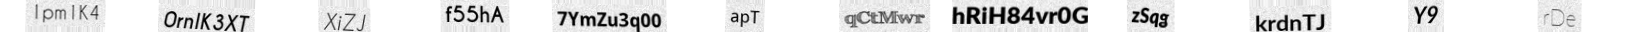

predictions ['', '', '', '', '', '', '', '', '', '', '', '']
500/500 [==============================] - 75s 150ms/step - loss: 28.4103
Epoch 2/20
500/500 [==============================] - ETA: 0s - loss: 27.0891WARNING:tensorflow:7 out of the last 12 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001EDC12C85E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


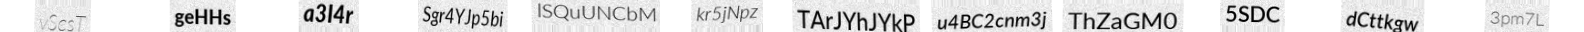

predictions ['', '', '', '', '', '', '', '', '', '', '', '']
500/500 [==============================] - 77s 153ms/step - loss: 27.0891
Epoch 3/20
500/500 [==============================] - ETA: 0s - loss: 22.8831WARNING:tensorflow:7 out of the last 11 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001EDC12C85E0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


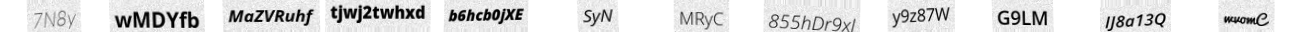

predictions ['7MgSY', 'wwMADYft', 'MMeZRuhf', 'amj2vhkm', '6kcA0jXE', 'SyM', 'MqG', 'SgSrBg', 'Wgg7WY', 'GgbM', 'ggo', 'c']
500/500 [==============================] - 75s 150ms/step - loss: 22.8831
Epoch 4/20
500/500 [==============================] - ETA: 0s - loss: 10.8634

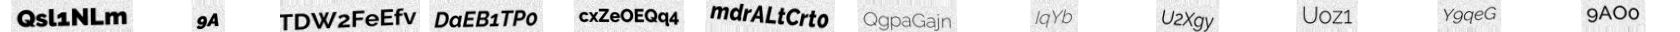

predictions ['QS4Klm', 'gA', 'TDWX2FeEFv', 'DaEB1TP0', 'cxZe0EQq4', 'fMdrALbCrt0', 'QggaGajr', 'qYb', 'U2Xgy', 'UJGZz1L', 'Y9qeG', 'S6AQ0']
500/500 [==============================] - 75s 150ms/step - loss: 10.8634
Epoch 5/20
500/500 [==============================] - ETA: 0s - loss: 7.4025

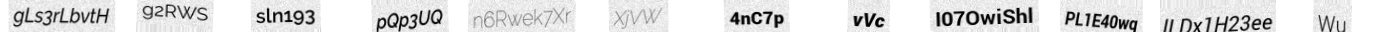

predictions ['gLs3rLbvtH', 'SSRWS', 'sUm1g3', 'pQp3UQ', 'mRweK7Xk', 'XyVW', '4mC7p', 'vVc', 'M070wiShI', 'PL1E0wq', 'um1H23ee', 'Wuy']
500/500 [==============================] - 72s 143ms/step - loss: 7.4025
Epoch 6/20
500/500 [==============================] - ETA: 0s - loss: 5.8799

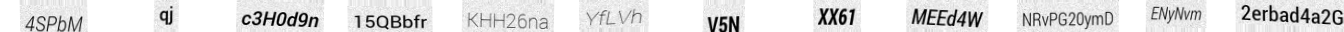

predictions ['4SPbM', 'qj', 'c3H0d9m', '15QBbf', 'KHH28ma', 'YfLh', '5M', 'XX61', 'MEEd4W', 'MRPG20ymD', '6ym', '2erbad4a2G']
500/500 [==============================] - 71s 141ms/step - loss: 5.8799
Epoch 7/20
500/500 [==============================] - ETA: 0s - loss: 5.0053

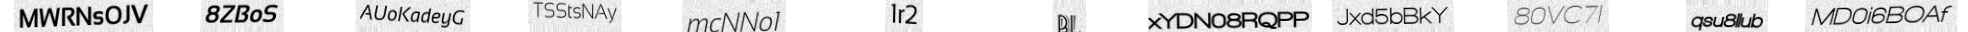

predictions ['MWRNSCJV', '8ZBdS', 'AUoKadeyG', 'tNAy', 'CNNj', '1r2', 'Bj', 'xYDNO8PmQFF', 'xd5bEkY', 'S0VO7I', 'qguBwub', 'MVDC6BC4Af']
500/500 [==============================] - 70s 140ms/step - loss: 5.0053
Epoch 8/20
500/500 [==============================] - ETA: 0s - loss: 4.4578

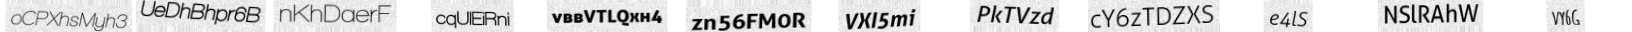

predictions ['oCFXhsMyh3', 'USDhBhDr6B', 'FKhDCerF', 'oqUEPml', 'veeVTLQxx4', 'zm56FM0R', 'VWIl5mi', 'PKTVzd', 'CY6ZTDZXS', 'e4lS', 'MSlRAhW', 'Yk']
500/500 [==============================] - 71s 141ms/step - loss: 4.4578
Epoch 9/20
500/500 [==============================] - ETA: 0s - loss: 4.0111

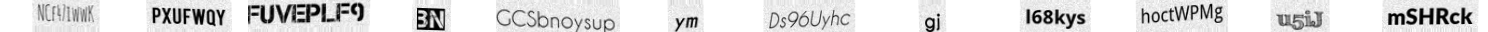

predictions ['MuitiwwM', 'PXUFWQY', 'fUVPlJ', 'B8', 'OCSbnoysup', 'ym', 'Ds96UJyhC', 'gj', 'I68kys', 'hoctWPMg', 't6i', 'nSHRck']
500/500 [==============================] - 70s 141ms/step - loss: 4.0111
Epoch 10/20
500/500 [==============================] - ETA: 0s - loss: 3.6615

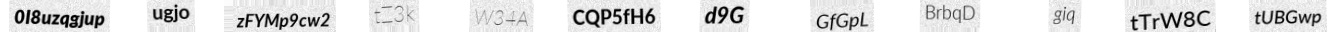

predictions ['0I8uzqgjup', 'ugjo', 'zFYNp9cw2', 'tZ3k', 'W34A', 'CQp5fH6', 'd9G', 'GfGpL', 'BrbqD', 'giq', 'tTrW8C', 'tUBGwp']
500/500 [==============================] - 69s 139ms/step - loss: 3.6615
Epoch 11/20
500/500 [==============================] - ETA: 0s - loss: 3.3726

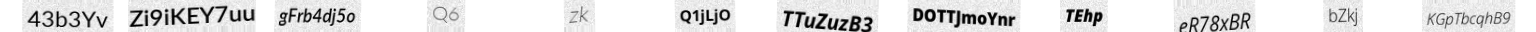

predictions ['43b3Yv', 'Zi9iKEY7uUu', 'gFrb4dj5o', 'Q6', 'zk', 'Q1jLjo', 'TTuZuz83', 'DOTTJmoYnr', 'TEhp', 'eR78xBR', 'bZkj', 'KGpTbqhB9']
500/500 [==============================] - 73s 145ms/step - loss: 3.3726
Epoch 12/20
500/500 [==============================] - ETA: 0s - loss: 3.1598

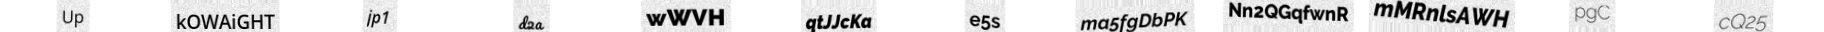

predictions ['Up', 'k0WAiGHT', 'Ip1', 'wa', 'wwVH', 'qhJcKa', 'e5s', 'ma5fgDbPK', 'Nm2QGqfwnR', 'mMRnlSAWH', 'pgC', 'cQ25']
500/500 [==============================] - 73s 146ms/step - loss: 3.1598
Epoch 13/20
500/500 [==============================] - ETA: 0s - loss: 2.9830

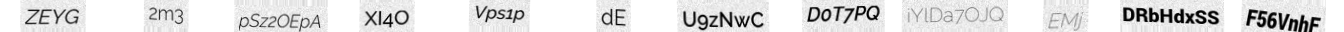

predictions ['ZEYG', '2m3', 'pSz2OEpA', 'XI4O', 'Vps1p', 'dE', 'U9zNwC', 'D0T7PQ', 'iYIDa70JQ', 'BMj', 'DRbHdxSS', 'F56WnhP']
500/500 [==============================] - 71s 142ms/step - loss: 2.9830
Epoch 14/20
500/500 [==============================] - ETA: 0s - loss: 2.7558

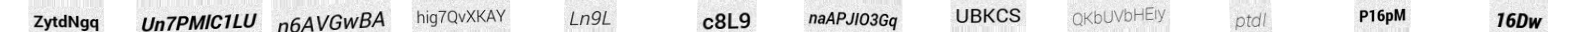

predictions ['zytdNgq', 'Un7PMIC1LU', 'n6AVGwBA', 'hg7QvXKAY', 'Ln9L', 'c8L9', 'naAPJI03Gq', 'UBKCS', 'QKbuvbHEIy', 'ptdI', 'P16pM', '16Dw']
500/500 [==============================] - 70s 140ms/step - loss: 2.7558
Epoch 15/20
500/500 [==============================] - ETA: 0s - loss: 2.6270

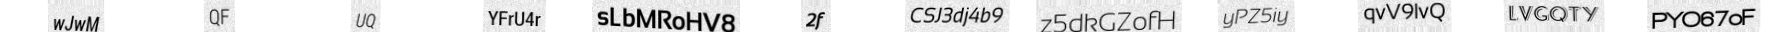

predictions ['wJwM', 'QF', 'UQ', 'YFrU4r', 'SLbMRoHV8', '2f', 'CSJ3dji4b9', 'z5dkOGZ0fH', 'yFPZ5iy', 'qvV9IvQ', 'LYgQTry', 'PYO67oF']
500/500 [==============================] - 70s 140ms/step - loss: 2.6270
Epoch 16/20
500/500 [==============================] - ETA: 0s - loss: 2.4317

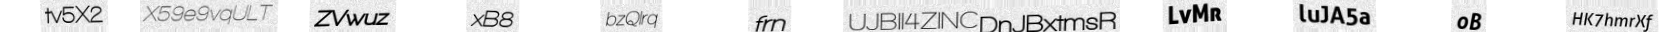

predictions ['t5X2', 'X59e9vqULT', 'ZVuz', 'xB8', 'bzQrq', 'fm', 'UUBlI4ZlNO', 'moBxtmsFR', 'LVMn', 'uJASa', 'oB', 'HK7hmrXf']
500/500 [==============================] - 71s 143ms/step - loss: 2.4317
Epoch 17/20
500/500 [==============================] - ETA: 0s - loss: 2.2896

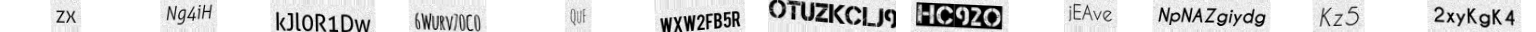

predictions ['Zx', 'Mg4iH', 'kJl0R1Dw', '6Wury70C0', 'QiF', 'wxW2Fb5R', 'JTUJZKClJ9i', 'Hc2c', 'iEAve', 'NpNAZgiydg', 'Kz5', '2xyKgK4']
500/500 [==============================] - 72s 145ms/step - loss: 2.2896
Epoch 18/20
500/500 [==============================] - ETA: 0s - loss: 2.1811

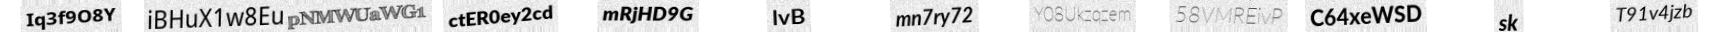

predictions ['tq3f9O8Y', 'iBHuX1W8Eu', 'pMWUaWG1', 'ctER0ey2cd', 'mRjHD9G', 'NvB', 'mn7ny72', 'Y08Ukzqzem', '58VMREivP', 'C64xeWSD', 'sk', 'T91v4jzb']
500/500 [==============================] - 73s 146ms/step - loss: 2.1811
Epoch 19/20
500/500 [==============================] - ETA: 0s - loss: 2.1050

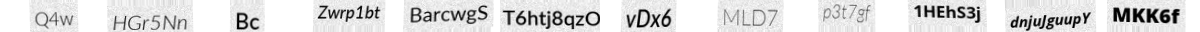

predictions ['Q4w', 'HGr5Nn', 'Bc', 'Zwrp1bt', 'BarcwgS', 'T6htj8qzO', 'vDX6', 'MLD7', 'p3t78f', '1HEhS3j', 'dnjuJguupY', 'MKK6f']
500/500 [==============================] - 70s 139ms/step - loss: 2.1050
Epoch 20/20
500/500 [==============================] - ETA: 0s - loss: 2.0406

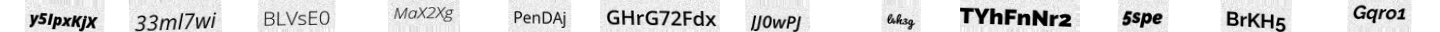

predictions ['y5Ipxkjx', '33ml7wj', 'BLVsE0', 'MaX2Xg', 'PenDAj', 'GHrG72Fdx', 'J0wP', 'whg', 'TYhFnNr2', '5spe', 'BrKH5', 'Gqro1']
500/500 [==============================] - 70s 140ms/step - loss: 2.0406


In [144]:
H = model.fit(datagen, epochs=20, verbose=1, callbacks=[predvis, model_saver])

# Image Preprocessing

In [145]:
pytesseract.pytesseract.tesseract_cmd = 'C:\\Program Files\\Tesseract-OCR\\tesseract.exe'

In [146]:
# Read the image
img = cv2.imread('4.png', 0)

# Apply image thresholding
img_thresh = cv2.adaptiveThreshold(img, 255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)

# Invert the image, 255 is the maximum value
img = 255 - img_thresh

# Detecting Words
words_pics = []
hImg, wImg = img.shape
boxes = pytesseract.image_to_data(img)
img_num = 10
for x,b in enumerate(boxes.splitlines()):
    if x != 0:
        b = b.split()
        if len(b) == 12:
            x,y,w,h = int(b[6]),int(b[7]),int(b[8]),int(b[9])
            words_pics.append(img[y-2:y+h+2,x-2:w+x+2])
            # Now predict
            im.fromarray(img[y-2:y+h+2,x-2:w+x+2]).convert('RGB').save(f'inference_test_imgs\\{img_num}.jpg', 'JPEG')

            
            img_num+=1
            
# Show the image
# cv2.imshow('Result',img)
# cv2.waitKey(0)

# Invert image
for i in words_pics:
    PIL.ImageOps.invert(im.fromarray(i)).convert('RGB').save(f'inference_test_imgs\\{img_num}.png', 'PNG')
    img_num+=1

# Text Prediction

model loaded


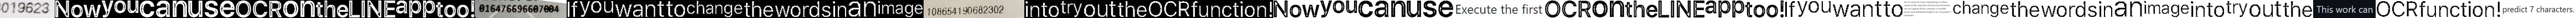

predictions ['0183623', '8niXBco5WdWM', 'W0MWr', 'k86e9W9WnM', 'kWB5c89e8', 'kuM3Wrn8M', 'k3U9MmW', '89nh5ec', 'MWBnNXBIBA', 'iC0Wf6nM', '8nco5coW', 'j815476696687a84R', 'hn', 'RWmWMW', 'BWnWMc9WWMnWhd', 'RW', 'WhM9Wn9We', 'BWWW9c', 'BWWWMWWWFq', 'BWW', 'f9eWWMW', 'MWMWMc9W9', 'H108654s682302', 'BWWnWWC', 'DpWWMWD', 'MWWWhd', 'BWWW9c', 'WGWMP8M', 'R9WWWWnMWWMWWMW', 'RNOR', '0Mwj', 'wCgG9OM', 'eQ989', 'Executethefirst', 'OCOR', '9CjOM', '9iG8', 'iiW0NICE', '58K0JBGO', 'MOCOf', 'lf', '0U', 'WVf8t0t', 'tO', 'ESSESESZE', 'CHn8n9c', 'th6', 'VOC0S', 'P', 'GCiO1', 'im899', 'ittCO', 'tCy', 'COUt', 'th6', 'WWMWMMWMWMMW', 'OGBQ', 'fUtOtiOt', 'predict7character']
inference time with image loading, model loading, preprocessing etc: 0.783289909362793


In [147]:
# do a test inference from the files in inference_test_imgs/
# why there are errors?
# - The model has been not trained on the domain, character size,
# character separation, margins, background
# overfitting to training data so use more regularization etc etc
start = time.time()
inference.inference_from_folder()
end = time.time()
print("inference time with image loading, model loading, preprocessing etc:", end - start)